In [1]:
# library time 
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# read in the dataset 
data = pd.read_excel("/Users/rwilfong/Downloads/BME 501 Homework 13 dataset.xlsx")

# check the dataframe 
data.head()

,id,age,tumor_size,inv_nodes,deg_malig,menopause,node_caps,breast,breast_quad,irradiat,class_num,Unnamed: 11,Unnamed: 12
0,1,45,17,1,3,2,1,2,1,0,1,NaN,NaN
1,2,55,17,1,1,1,0,2,5,0,0,NaN,id: id number of the patient
2,3,55,37,1,2,1,0,1,2,0,1,NaN,NaN
3,4,45,37,1,3,2,1,2,2,1,0,NaN,age: age of the patient
4,5,45,32,4,2,2,1,1,3,0,1,NaN,NaN


In [3]:
# remove unwanted columns
data = data.drop(columns=['Unnamed: 11', 'Unnamed: 12'])

# check the data output 
data.head()


,id,age,tumor_size,inv_nodes,deg_malig,menopause,node_caps,breast,breast_quad,irradiat,class_num
0,1,45,17,1,3,2,1,2,1,0,1
1,2,55,17,1,1,1,0,2,5,0,0
2,3,55,37,1,2,1,0,1,2,0,1
3,4,45,37,1,3,2,1,2,2,1,0
4,5,45,32,4,2,2,1,1,3,0,1


## Question 1
Create a shallow neural network with one input layer, one hidden layer, and an output layer 

Hidden layer
- 4 neurons
- Batch normalization applied
- ReLU activation function


Output layer
- Softmax activation function


Training parameters
- Maximum of 500 epochs
- Initial learning rate of 0.01

Training on all of the data from the patients (1-222) and then testing it on the rest of the data (223-277)

In [4]:
# peek at the data 
data

,id,age,tumor_size,inv_nodes,deg_malig,menopause,node_caps,breast,breast_quad,irradiat,class_num
0,1,45,17,1,3,2,1,2,1,0,1
1,2,55,17,1,1,1,0,2,5,0,0
2,3,55,37,1,2,1,0,1,2,0,1
3,4,45,37,1,3,2,1,2,2,1,0
4,5,45,32,4,2,2,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
272,273,55,32,7,2,1,1,1,2,0,0
273,274,55,27,4,2,2,1,1,2,1,0
274,275,35,32,7,2,2,1,2,3,0,0
275,276,55,17,1,2,2,0,2,2,0,0


Separate the training and test sets 

In [5]:
# identify the training and test sets
train_data = data.iloc[:222]
test_data = data.iloc[222:]

# separate features and target
X_train = train_data.drop(columns=["class_num", "id"])
y_train = train_data["class_num"]
X_test = test_data.drop(columns=["class_num", "id"])
y_test = test_data["class_num"]


In [6]:
# preprocess categorical and numerical columns
# define the categorical and numerical features 
categorical_features = ["deg_malig", "menopause", "node_caps", "breast", "breast_quad", "irradiat"]
numerical_features = ["age", "tumor_size", "inv_nodes"]

# create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features), # scale the num. data
        ("cat", OneHotEncoder(), categorical_features), # apply one-hot encoding
    ]
)

In [7]:
# apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
# create the model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # input layer
    layers.Dense(4),  # hidden layer with 4 neurons
    layers.BatchNormalization(),  # batch normalization
    layers.Activation("relu"),  # ReLU activation function
    layers.Dense(2, activation="softmax")  # output layer with softmax
])

In [9]:
# compile the model 
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
# train!
history = model.fit(
    X_train, y_train,
    epochs=500,
    verbose=0
)

In [11]:
# predict on the test data
y_pred_probs = model.predict(X_test)  # predicted probabilities
y_pred = y_pred_probs.argmax(axis=1)  # convert to class predictions

# construct the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()  # extract TN, FN, TP, FP

# calculate metrics
sensitivity = tp / (tp + fn)  # sensitivity 
recall = sensitivity  # same as sensitivity
specificity = tn / (tn + fp)  # specificity
positive_predicted_value = tp / (tp + fp)  # positive predicted value 
precision = positive_predicted_value  # same as positive predicted value
negative_predicted_value = tn / (tn + fn)  # negative predicted value
accuracy = accuracy_score(y_test, y_pred)  # accuracy
f1_score = 2 * (precision * recall) / (precision + recall)  # f1-score

# return the confusion matrix and metrics
print("Confusion Matrix:")
print(cm)
print("\nMetrics:")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Positive Predicted Value (Precision): {positive_predicted_value:.2f}")
print(f"Negative Predicted Value: {negative_predicted_value:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1_score:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Confusion Matrix:
[[32 10]
 [ 6  7]]

Metrics:
Sensitivity (Recall): 0.54
Specificity: 0.76
Positive Predicted Value (Precision): 0.41
Negative Predicted Value: 0.84
Accuracy: 0.71
F1-Score: 0.47


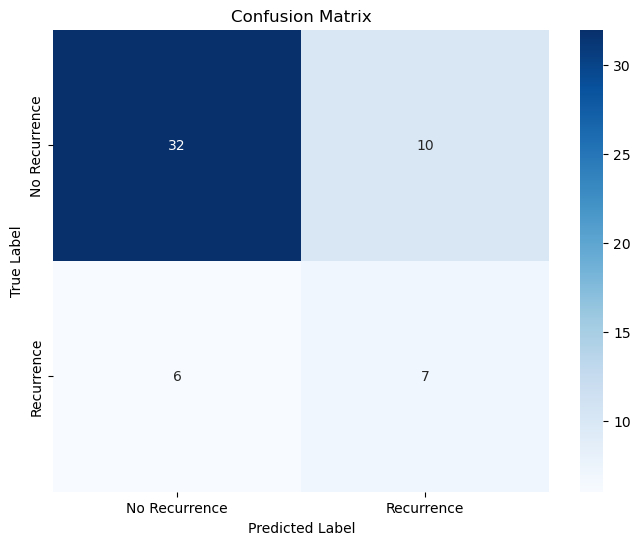

In [12]:
# turn confusion matrix into figure
import matplotlib.pyplot as plt
import seaborn as sns

# plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recurrence", "Recurrence"], yticklabels=["No Recurrence", "Recurrence"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()